In [1]:
import torch
from torch_geometric.nn import GCNConv, ChebConv  # noqa
import time
import networkx as nx
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
from best_params import best_params_dict
import data as dt

/users/s1f101810026/miniconda3/envs/grand/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import importlib
# importlib.reload(sys.modules['grand_discritized'])
# importlib.reload(sys.modules['run_grand_ex'])
from grand_discritized import GrandExtendDiscritizedNet
from run_grand_ex import get_optimizer, train, test


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
opt = {'depth': 512, 'trunc_alpha': 0, 'discritize_type':'norm', 'step_size':0.01, 'one_block':True}
best_opt = best_params_dict['Cora']
opt = {**opt, **best_opt}
# opt['epoch'] = 100
# opt['hidden_dim'] = 30
opt['batch_norm'] = False
# opt['attention_dim'] = 128

In [4]:
# dataset = dt.get_dataset('Cora', '../data', use_lcc=True)
dataset = dt.get_dataset(opt, '../data', opt['not_lcc'])
# dataset = dt.get_dataset({'dataset':'Cora', 'rewiring' : None}, '/content/graph-neural-pde/data', use_lcc=True) 
print(dataset.data.num_nodes, dataset.data.num_edges)

2485 10138


In [5]:
model, dat = GrandExtendDiscritizedNet(opt, dataset, device).to(device), dataset.data.to(device)

In [6]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = get_optimizer(opt['optimizer'], parameters, lr=opt['lr'], weight_decay=opt['decay'])

In [7]:
import tqdm

best_val_acc = test_acc = best_epoch = 0
for epoch in tqdm.tqdm(range(1, opt['epoch'])):
    start_time = time.time()

    loss, train_label_r, train_all_r = train(model, optimizer, dat)
    # print("STARTING RUN TEST")
    [train_acc, val_acc, tmp_test_acc], outs, label_r, all_label_r = test(model, dat, debug=True)
    # if train_acc==1:
    #     print(f"Reaching 0-error point at epoch {epoch}")
    if val_acc > best_val_acc:
        best_train_acc = train_acc
        best_val_acc = val_acc
        test_acc = tmp_test_acc
        best_epoch = epoch
        best_outs = outs
        best_label_r = train_label_r
        best_all_label_r = train_all_r
    # print(f'Loss: {loss}, Local R: {label_r}, Label Representive R: {all_label_r}')
    # log = 'Epoch: {:03d}, Runtime {:03f}, Loss {:03f}, forward nfe {:d}, backward nfe {:d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    # print(
    #   log.format(epoch, time.time() - start_time, loss, model.fm.sum, model.bm.sum, train_acc, best_val_acc, test_acc))
    # print('best val accuracy {:03f} with test accuracy {:03f} at epoch {:d}'.format(best_val_acc, test_acc, best_epoch))

100%|██████████| 99/99 [01:54<00:00,  1.16s/it]


In [8]:
print(best_train_acc, test_acc, best_epoch, best_label_r, best_all_label_r)

0.9952380952380953 0.86497461928934 61 tensor(0.0302, device='cuda:0', grad_fn=<CloneBackward0>) tensor(0.6501, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
plt.hist(np.array(torch.distributions.cauchy.Cauchy(0,0.001).expand([1000]).sample()))

(array([  1.,  30., 115., 307., 489., 605., 519., 287., 101.,  31.]),
 array([-0.84858644, -0.6829965 , -0.51740664, -0.3518167 , -0.18622681,
        -0.02063692,  0.14495298,  0.31054288,  0.4761328 ,  0.6417227 ,
         0.8073126 ], dtype=float32),
 <BarContainer object of 10 artists>)

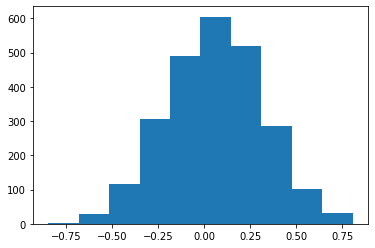

In [9]:
plt.hist(np.array(best_outs[2][2][:,15].cpu()))

In [ ]:
check = np.array([torch.norm(out, dim=-1).cpu().numpy() for out in best_outs[1]])
plt.hist(check[10,dat.cpu().val_mask])

In [ ]:
best_outs[1][opt['depth']].corrcoef()

In [ ]:
torch.norm(best_outs[1][0][10],dim=-1)

In [ ]:
len(best_outs[1])

In [ ]:
#Norm of hidden_dim
plt.figure(figsize=(16, 9))
for dim in range(opt['hidden_dim']):
    plt.scatter([i for i in range(opt['depth']*3+1)],[torch.norm(out,dim=0)[dim].cpu().numpy() for out in best_outs[1]], label=dim)

plt.legend()

In [ ]:
#Norm of first 10 nodes
plt.figure(figsize=(16, 9))
start = 100
end = start+20
for node in range(start,end):
    plt.scatter([i for i in range(opt['depth']*3+1)],[torch.norm(out[node],dim=-1).cpu().numpy() for out in best_outs[1]], label=node)

plt.legend()

In [ ]:
#Norm all
plt.figure(figsize=(16, 9))
#2485
for dim in range(50):
    plt.scatter([i for i in range(opt['depth']*3+1)][0:],[torch.norm(out).cpu().numpy() for out in best_outs[1]][0:], label=dim)

plt.legend()

In [ ]:
best_outs[1][0].size()

In [ ]:
best_outs[1][0]

In [ ]:
len(times_x[0])

/tmp/ipykernel_1881107/1767237090.py:57: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


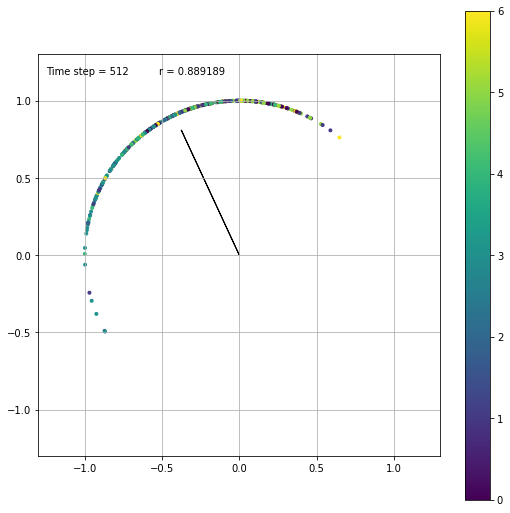

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import plotly.express as px
import pandas as pd

start = 0
end = dataset.data.num_nodes
# end = 100
# opt['depth'] = opt['depth']*3
t = [i for i in range(opt['depth']+1) for _ in range(start,end)]
res_x = []
res_y = []
# [res_x.extend(torch.sin(torch.norm(time[start:end],dim=1)).cpu().numpy()) for time in best_outs[1]]
# [res_y.extend(torch.cos(torch.norm(time[start:end],dim=1)).cpu().numpy()) for time in best_outs[1]]
[res_x.extend(torch.sin(torch.mean(time[start:end],dim=-1)).cpu().numpy()) for time in best_outs[1]]
[res_y.extend(torch.cos(torch.mean(time[start:end],dim=-1)).cpu().numpy()) for time in best_outs[1]]
color = [node for _ in range(opt['depth']+1) for node in range(start,end)]
df = pd.DataFrame()
df['time'] = t
df['y'] = res_x
df['x'] = res_y
df['color'] = color
df['is_train'] = [mask for _ in range(opt['depth']+1) for mask in dat.train_mask.cpu().numpy()[start:end]]
df['node_label'] = [label for _ in range(opt['depth']+1)for label in dat.y.cpu().numpy()[start:end]]
unique_node = np.unique(df['node_label']).shape[0]

df = df[df['is_train']==True]
# df = df[df['node_label']==1]
time_steps = opt['depth']+1
# r_cos = [torch.cos(torch.norm(time[start:end],dim=1)).cpu().numpy().mean() for time in best_outs[1]]
# r_sin = [torch.sin(torch.norm(time[start:end],dim=1)).cpu().numpy().mean() for time in best_outs[1]]
times_x = []
times_y = []
times_label = []
r_cos = []
r_sin = []
node_order = [i for i in range(start,end)]
node_label = df['node_label']
for i in range(time_steps):
    times_x.append(df[df['time']==i]['x'].values)
    times_y.append(df[df['time']==i]['y'].values)
    r_cos.append(sum(times_x[i])/len(times_x[i]))
    r_sin.append(sum(times_y[i])/len(times_y[i]))
    times_label.append(df[df['time']==i]['node_label'].values)
fig, ax = plt.subplots(figsize=(9,9))
marker_size = 35 #upped this to make points more visible
r = np.sqrt(np.array(r_sin)**2 + np.array(r_cos)**2)
def animate(i):
    """ Perform animation step. """
    #important - the figure is cleared and new axes are added
    fig.clear()
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(-1.3, 1.3), ylim=(-1.3, 1.3))
    #the new axes must be re-formatted
    ax.set_xlim(-1.3,1.3)
    ax.set_ylim(-1.3,1.3)
    ax.grid(b=None)
    # ax.set_xlabel('x [m]')
    # ax.set_ylabel('y [m]')
    # and the elements for this frame are added
    ax.text(0.02, 0.95, 'Time step = %d' % i, transform=ax.transAxes)
    ax.text(0.3, 0.95, 'r = %f' % r[i], transform=ax.transAxes)
    # print(times_x[i][:])
    ax.arrow(0,0, r_cos[i], r_sin[i])
    s = ax.scatter(times_x[i][:], times_y[i][:], s = marker_size, c = times_label[i][:], marker = ".", edgecolor = None)
    # ax.legend()
    fig.colorbar(s, ticks=range(0,unique_node))

ani = animation.FuncAnimation(fig, animate, interval=100, frames=range(time_steps))
ani.save('cora_omega_vae.gif', writer='pillow')

In [77]:
data[:,label==1].mean(dim=-1)

tensor([-0.0065,  3.5670,  3.5721,  ...,  3.2645,  3.2644,  3.2644],
       device='cuda:0')

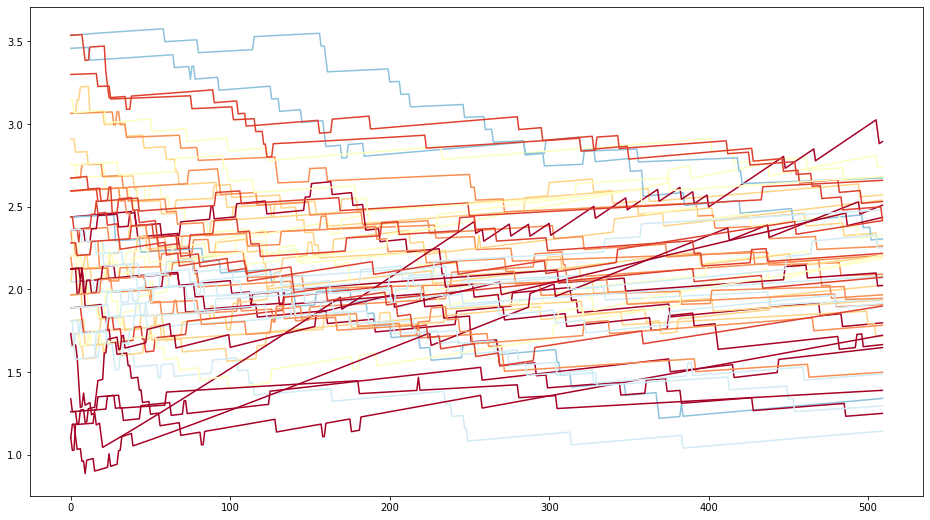

In [17]:
data = torch.stack(best_outs[1],dim=0)
data = data[3:,:]
data = torch.mean(data, dim=-1)
data = data[:,dat.test_mask.cpu().numpy()]
label = dat.y.cpu()[dat.test_mask.cpu()]
plt.figure(figsize=(16, 9))
for node in range(50):
    plt.plot([i for i in range(data.size(0))], data[:,node].cpu(), c=plt.cm.RdYlBu(label[node].numpy()/8))
plt.show()

In [ ]:
best_outs[1][0].size()

In [ ]:
dat.y.cpu().numpy()

In [ ]:
plt.scatter(df['x'],df['y'], label=df['time'])


In [ ]:
import matplotlib.animation as animation

def update_plot(i, data, scat):
    scat.set_array(data[i])
    return scat,

#dynamic of 10 nodes, 0 and 1 features
plt.figure(figsize=(16, 9))
#2485
start = 0
end = start+1
data = []
label = []
for node in range(start,end):
#     pca_result = pca.transform([out[node].cpu().numpy() for out in best_outs[1]][0:])
# # df['pca-one'] = pca_result[:,0]
# # df['pca-two'] = pca_result[:,1] 
#     plt.scatter(pca_result[:,0], pca_result[:,1], label=node)

    plt.scatter([torch.sin(out[node][0]).cpu().numpy() for out in best_outs[1]][0:],
                [torch.cos(out[node][0]).cpu().numpy() for out in best_outs[1]][0:], label=node)

plt.show()



In [ ]:

plt.legend()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#dynamic of 10 nodes, 0 and 1 features
plt.figure(figsize=(16, 9))
#2485
start = 1
end = start+100
data = []
label = []
for node in range(start,end):
    data.extend([out[node].cpu().numpy() for out in best_outs[1]])
    label.extend([dat.y[start:end] for _ in range(opt['depth'] + 1)])
pca = PCA(n_components=2)
pca.fit(data)
# plt.scatter(pca_result[:,0], pca_result[:,1])

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(data)
# plt.scatter(tsne_results[:,0], tsne_results[:,1])
for node in range(start,end):
    pca_result = pca.transform([out[node].cpu().numpy() for out in best_outs[1]][0:])
# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
    plt.scatter(pca_result[:,0], pca_result[:,1], label=dat.y[node].cpu().numpy())

    # plt.scatter([out[node+10][0].cpu().numpy() for out in best_outs[1]][0:],[out[node+10][1].cpu().numpy() for out in best_outs[1]][0:], label=dim)

plt.legend()

In [ ]:
for node in range(start,end):
    if not dat.train_mask[node]:
        continue
    pca_result = pca.transform([out[node].cpu().numpy() for out in best_outs[1]][0:])
    print(pca_result[-1,0], pca_result[-1,1], dat.y[node].cpu().numpy(), dat.train_mask[node].cpu().numpy())

In [ ]:
dat.train_mask